### Imports Cell

In [ ]:
import os, sys, math, time, yaml, importlib, types, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from pathlib import Path
import time
from pathlib import Path
import time
from pathlib import Path
import numpy as np, cv2, math, importlib, types
from datetime import datetime
from collections import deque
from datetime import datetime
from sklearn.cluster import KMeans

### Configuration Cell

In [ ]:
# ==== CONFIG ====

CONFIG = {
    "paths": {
        "video": "data/raw/input.mp4",     # auto-picks first video in data/raw if missing
        "weights": "models/yolov8n.pt",    # valid local file preferred; safe loader will fallback by name if broken
        "outputs_dir": "outputs",
        "out_video_name": None             # auto if None
    },
    "yolo": {
        "imgsz": 1536,          # ↑ helps tiny ball & small jerseys
        "conf_person": 0.35,    # ↓ recall up (we filter by pitch)
        "conf_ball": 0.12,
        "iou_nms": 0.50         # a bit stricter NMS
    },
    "teams": {
        "sample_ratio": 0.45,              # jersey color patch from bbox center
        "jersey_hsv_mask": {"s_min": 40, "v_min": 40},
        "non_green_hue_range": (35, 90),   # exclude pitch green (HSV in OpenCV 0..179)
        "ema_alpha": 0.15,
        "min_players_for_cluster": 3
    },
    "ocr": {
        "enabled": True,        # show jersey numbers; set False to disable
        "engine": "tesseract",  # tesseract first; we still fallback to easyocr if available
        "min_bbox_h": 64,       # only OCR when box is tall enough
        "roi": {"top": 0.25, "bottom": 0.85, "left": 0.18, "right": 0.82},  # torso/back ROI
        "preprocess": {"sharpen": True, "adaptive_thresh": True, "denoise": True},
        "keep_numeric_only": True,
        "valid_len": (1, 2),
        "sample_every_n_frames": 2,
        "upsample": 2
    },
    "ball": {
        "fallback_hough": True,
        "min_rel_area": 2e-5,
        "max_rel_area": 8e-4,
        "prefer_lower_half": True
    },
    "viz": {
        "draw_thickness": 2,
        "font_scale": 0.6
    },
    "tracking": {
        "enabled": True,
        "iou_match": 0.4,
        "max_age": 24,
        "vote_len": 7        # OCR number voting buffer length      # keep tracks longer when detector blinks
    },
    "runtime": {
        "preview_frames": 250,  # change for quick tests
        "full_run": False
    }
}

# Prepare outputs
paths = CONFIG["paths"]
outputs_root = Path(paths["outputs_dir"])
(outputs_root / "videos").mkdir(parents=True, exist_ok=True)
(outputs_root / "frames").mkdir(parents=True, exist_ok=True)
(outputs_root / "logs").mkdir(parents=True, exist_ok=True)

if not paths["out_video_name"]:
    stem = Path(paths["video"]).stem
    paths["out_video_name"] = f"{stem}_annotated_{time.strftime('%Y%m%d_%H%M%S')}.mp4"

CONFIG


{'paths': {'video': 'data/raw/input.mp4',
  'weights': 'models/yolov8n.pt',
  'outputs_dir': 'outputs',
  'out_video_name': 'input_annotated_20250824_084715.mp4'},
 'yolo': {'imgsz': 1536,
  'conf_person': 0.35,
  'conf_ball': 0.12,
  'iou_nms': 0.5},
 'teams': {'sample_ratio': 0.45,
  'jersey_hsv_mask': {'s_min': 40, 'v_min': 40},
  'non_green_hue_range': (35, 90),
  'ema_alpha': 0.15,
  'min_players_for_cluster': 3},
 'ocr': {'enabled': True,
  'engine': 'tesseract',
  'min_bbox_h': 64,
  'roi': {'top': 0.25, 'bottom': 0.85, 'left': 0.18, 'right': 0.82},
  'preprocess': {'sharpen': True, 'adaptive_thresh': True, 'denoise': True},
  'keep_numeric_only': True,
  'valid_len': (1, 2),
  'sample_every_n_frames': 2,
  'upsample': 2},
 'ball': {'fallback_hough': True,
  'min_rel_area': 2e-05,
  'max_rel_area': 0.0008,
  'prefer_lower_half': True},
 'viz': {'draw_thickness': 2, 'font_scale': 0.6},
 'tracking': {'enabled': True, 'iou_match': 0.4, 'max_age': 24, 'vote_len': 7},
 'runtime': {'p

### Path and Video Setup Cell


c:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[INFO] Using video: data\raw\CV_Task.mkv


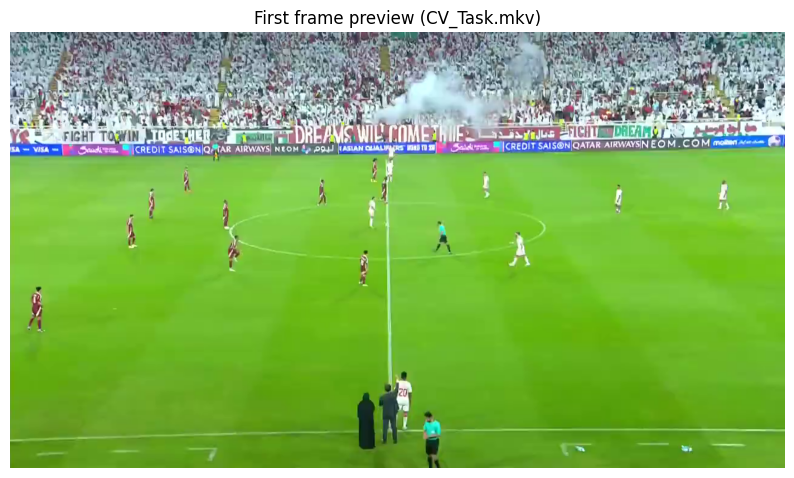

Frame size: 1280x720


In [ ]:
# ==== IMPORTS & SANITY ====
# !pip install ultralytics==8.2.62 opencv-python==4.10.0.84 numpy==1.26.4 scikit-learn==1.4.2 matplotlib==3.8.4 pyyaml==6.0.1

try:
    from ultralytics import YOLO
except Exception as e:
    print("Ultralytics not available:", e)

# Auto-pick video if missing
video_path = Path(CONFIG["paths"]["video"])
if not video_path.exists():
    raw_dir = Path("data/raw")
    supported_exts = [".mp4", ".mkv", ".avi", ".mov"]
    candidates = [f for f in raw_dir.glob("*") if f.suffix.lower() in supported_exts]
    if not candidates:
        raise FileNotFoundError(f"No video found in {raw_dir}. Supported: {supported_exts}")
    video_path = candidates[0]
    CONFIG["paths"]["video"] = str(video_path)
    print(f"[INFO] Using video: {video_path}")

# Show first frame
cap = cv2.VideoCapture(str(video_path))
ok, frame0 = cap.read()
cap.release()
assert ok and frame0 is not None, f"Unable to read first frame of {video_path}"

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB))
plt.title(f"First frame preview ({video_path.name})")
plt.axis("off")
plt.show()

H0, W0 = frame0.shape[:2]
print(f"Frame size: {W0}x{H0}")
 

### Helper Functions Cell


In [ ]:
# ==== HELPERS (ALL-IN-ONE) ====


# ---------- draw ----------
def draw_bbox(img, box, label=None, color=(0,255,0), thickness=2):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1,y1), (x2,y2), color, thickness)
    if label:
        cv2.putText(img, label, (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, CONFIG["viz"]["font_scale"], color,
                    CONFIG["viz"]["draw_thickness"], cv2.LINE_AA)

def next_versioned_path(base_dir, stem, suffix=".mp4"):
    base = Path(base_dir); base.mkdir(parents=True, exist_ok=True)
    pattern = re.compile(rf"^{re.escape(stem)}_v(\d+)\{re.escape(suffix)}$")
    existing = [p for p in base.glob(f"{stem}_v*{suffix}")]
    if not existing: return base / f"{stem}_v01{suffix}"
    nums = []
    for p in existing:
        m = pattern.match(p.name)
        if m: nums.append(int(m.group(1)))
    nxt = (max(nums) + 1) if nums else 1
    return base / f"{stem}_v{nxt:02d}{suffix}"

# ---------- pitch ----------
def pitch_mask(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower = np.array([35, 40, 40], dtype=np.uint8)
    upper = np.array([90, 255, 255], dtype=np.uint8)
    m = cv2.inRange(hsv, lower, upper)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8))
    return m

def inner_pitch_mask(mask, shrink_px=28):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*shrink_px+1, 2*shrink_px+1))
    inner = cv2.erode(mask, k, iterations=1)
    return inner

def bbox_on_inner_pitch(inner_mask, box, min_overlap_ratio=0.20):
    x1,y1,x2,y2 = map(int, box)
    h,w = inner_mask.shape[:2]
    x1 = max(0, min(w-1, x1)); x2 = max(0, min(w-1, x2))
    y1 = max(0, min(h-1, y1)); y2 = max(0, min(h-1, y2))
    if x2<=x1 or y2<=y1: return False
    crop = inner_mask[y1:y2, x1:x2]
    area = crop.size; overlap = int((crop>0).sum())
    return area>0 and (overlap/float(area) >= min_overlap_ratio)

# ---------- jersey features & ROI ----------
def center_patch_from_box(frame, box, ratio=None):
    if ratio is None: ratio = CONFIG["teams"]["sample_ratio"]
    x1, y1, x2, y2 = map(int, box)
    w, h = x2 - x1, y2 - y1
    cx1 = x1 + int((1 - ratio) * 0.5 * w)
    cy1 = y1 + int((1 - ratio) * 0.5 * h)
    cx2 = cx1 + int(ratio * w)
    cy2 = cy1 + int(ratio * h)
    cx1, cy1 = max(cx1, x1), max(cy1, y1)
    cx2, cy2 = min(cx2, x2), min(cy2, y2)
    return frame[cy1:cy2, cx1:cx2]

def crop_jersey_roi(frame, box):
    x1, y1, x2, y2 = map(int, box)
    h, w = y2 - y1, x2 - x1
    if w <= 0 or h <= 0: return np.zeros((0,0,3), dtype=np.uint8)
    r = CONFIG["ocr"]["roi"]
    rx1 = x1 + int(w * r["left"]);  rx2 = x1 + int(w * r["right"])
    ry1 = y1 + int(h * r["top"]);   ry2 = y1 + int(h * r["bottom"])
    H, W = frame.shape[:2]
    rx1 = max(0, min(W, rx1)); rx2 = max(0, min(W, rx2))
    ry1 = max(0, min(H, ry1)); ry2 = max(0, min(H, ry2))
    if rx2 <= rx1 or ry2 <= ry1: return np.zeros((0,0,3), dtype=np.uint8)
    return frame[ry1:ry2, rx1:rx2]

def jersey_feature_hsv(frame, box):
    patch = center_patch_from_box(frame, box)
    if patch.size == 0: return None
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    H,S,V = hsv[...,0], hsv[...,1], hsv[...,2]
    s_min = CONFIG["teams"]["jersey_hsv_mask"]["s_min"]
    v_min = CONFIG["teams"]["jersey_hsv_mask"]["v_min"]
    h_lo, h_hi = CONFIG["teams"]["non_green_hue_range"]
    non_green = (H < h_lo) | (H > h_hi)
    mask = (S > s_min) & (V > v_min) & non_green
    sel = hsv[mask]
    if sel.size == 0: return None
    var = sel.var(axis=0)
    feat = sel.mean(axis=0).astype(np.float32)
    if feat[2] < 60 and var.mean() < 300:  # dark & uniform → nudge away
        feat = feat.copy(); feat[0] = (feat[0] + 180) % 180
    return feat

# ---------- two-team clustering + referee heuristic ----------
class Team2Clustering:
    def __init__(self, alpha=0.2):
        self.alpha = alpha; self.cents = None; self.valid = False
    def fit_first(self, feats):
        from sklearn.cluster import KMeans
        km = KMeans(n_clusters=2, n_init=10, random_state=42)
        labs = km.fit_predict(feats)
        self.cents = km.cluster_centers_.astype(np.float32)
        self.valid = True
        return labs
    def assign(self, feats):
        d0 = np.linalg.norm(feats - self.cents[0], axis=1)
        d1 = np.linalg.norm(feats - self.cents[1], axis=1)
        labs = (d1 < d0).astype(int)
        for k in [0,1]:
            if np.any(labs==k):
                newc = feats[labs==k].mean(axis=0)
                self.cents[k] = (1-self.alpha)*self.cents[k] + self.alpha*newc
        return labs
    def fit_predict(self, feats):
        return self.fit_first(feats) if not self.valid or self.cents is None else self.assign(feats)

def referee_color_heuristic(featHSV):
    H,S,V = featHSV
    black_like = V < 60
    neon_yellow = (20 <= H <= 40) and (S > 120) and (V > 120)
    return black_like or neon_yellow

def far_from_teams(feat, cents, tau=45.0):
    if cents is None: return False
    d0 = np.linalg.norm(feat - cents[0]); d1 = np.linalg.norm(feat - cents[1])
    return min(d0,d1) > tau

# ---------- robust YOLO loader ----------
def safe_load_yolo(weights_path_str: str, fallback_name: str = "yolov8n.pt"):
    from ultralytics import YOLO
    wp = Path(weights_path_str)
    def looks_ok(p: Path) -> bool:
        return p.exists() and p.suffix.lower() in {".pt", ".onnx"} and p.stat().st_size > 1_000_000
    if looks_ok(wp):
        try:
            print(f"[INFO] Loading local weights: {wp} ({wp.stat().st_size/1e6:.1f} MB)")
            return YOLO(str(wp))
        except (EOFError, RuntimeError, ValueError, OSError) as e:
            bad = wp.with_suffix(wp.suffix + f".corrupt_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
            try:
                wp.rename(bad)
                print(f"[WARN] Corrupted weights ({type(e).__name__}). Quarantined as: {bad.name}")
            except Exception as re:
                print(f"[WARN] Could not quarantine corrupted weights: {re}")
    elif wp.exists():
        print(f"[WARN] Weights at {wp} look invalid (size={wp.stat().st_size} bytes, suffix={wp.suffix}).")
    else:
        print(f"[INFO] No local weights at {wp}. Falling back to '{fallback_name}'.")
    print(f"[INFO] Loading fallback model: {fallback_name}")
    return YOLO(fallback_name)

# ---------- tracking (with number voting) ----------
def box_iou(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    if inter == 0: return 0.0
    area_a = (ax2-ax1)*(ay2-ay1); area_b = (bx2-bx1)*(by2-by1)
    return inter / (area_a + area_b - inter + 1e-6)

class IOUTracker:
    def __init__(self, iou_thr=0.4, max_age=15, vote_len=5):
        self.iou_thr = iou_thr; self.max_age = max_age
        self.vote_len = vote_len
        self.next_id = 1
        self.tracks = {}  # id -> {"box":..., "miss":0, "number":None, "number_votes": deque([...])}
    def update(self, boxes):
        for tid in list(self.tracks.keys()):
            self.tracks[tid]["miss"] += 1
            if self.tracks[tid]["miss"] > self.max_age:
                del self.tracks[tid]
        assigned = set()
        for b in boxes:
            best_iou, best_id = 0.0, None
            for tid, trk in self.tracks.items():
                iou = box_iou(b, trk["box"])
                if iou > best_iou:
                    best_iou, best_id = iou, tid
            if best_iou >= self.iou_thr and best_id not in assigned:
                self.tracks[best_id]["box"] = list(map(int, b))
                self.tracks[best_id]["miss"] = 0
                assigned.add(best_id)
            else:
                tid = self.next_id; self.next_id += 1
                self.tracks[tid] = {
                    "box": list(map(int, b)),
                    "miss": 0,
                    "number": None,
                    "number_votes": deque(maxlen=self.vote_len),
                }
                assigned.add(tid)
        return {tid: trk for tid, trk in self.tracks.items()}

# ---------- ball helpers ----------
def box_center(b): return ((b[0]+b[2])//2, (b[1]+b[3])//2)
def feet_points(b):
    x1,y1,x2,y2 = b
    cx = (x1+x2)//2
    return [(cx, y2-2), (x1+int(0.2*(x2-x1)), y2-2), (x1+int(0.8*(x2-x1)), y2-2)]
def near_any_player_feet(ball_box, player_boxes, max_px=140):
    bx, by = box_center(ball_box)
    for pb in player_boxes:
        for fp in feet_points(pb):
            if (fp[0]-bx)**2 + (fp[1]-by)**2 <= max_px**2:
                return True
    return False

# ---------- OCR (tesseract-first with fallback to easyocr) ----------
def ocr_read_number(bgr_crop):
    """
    Robust jersey number OCR:
    - Upsamples
    - Binary + inverted variants + light morphology
    - Tesseract first (digit allowlist), EasyOCR fallback
    Returns: digits or None
    """
    if bgr_crop is None or bgr_crop.size == 0:
        return None

    up = CONFIG["ocr"].get("upsample", 2)
    if up and up > 1:
        bgr = cv2.resize(bgr_crop, None, fx=up, fy=up, interpolation=cv2.INTER_CUBIC)
    else:
        bgr = bgr_crop

    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.medianBlur(g, 3)
    g_ad = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
    g_inv = cv2.bitwise_not(g_ad)
    k = np.ones((2,2), np.uint8)
    g_ad = cv2.morphologyEx(g_ad, cv2.MORPH_CLOSE, k, iterations=1)
    g_inv = cv2.morphologyEx(g_inv, cv2.MORPH_CLOSE, k, iterations=1)
    variants = [g_ad, g_inv]

    fm = cv2.Laplacian(g, cv2.CV_64F).var()
    if fm < 60:
        return None

    # Tesseract
    try:
        import pytesseract
        cfg = "--psm 7 --oem 1 -c tessedit_char_whitelist=0123456789"
        for img in variants:
            txt = pytesseract.image_to_string(img, config=cfg)
            txt = "".join(ch for ch in txt if ch.isdigit())
            if txt:
                lo, hi = CONFIG["ocr"]["valid_len"]
                if lo <= len(txt) <= hi:
                    return txt
    except Exception:
        pass

    # EasyOCR fallback
    try:
        import easyocr, torch
        if not hasattr(torch, "version"):
            torch.version = types.SimpleNamespace()
            torch.version.__version__ = torch.__version__
        if not hasattr(torch, "_utils"):
            torch._utils = importlib.import_module("torch.utils")
        reader = easyocr.Reader(['en'], gpu=False)
        for img in variants:
            res = reader.readtext(img, detail=0, allowlist="0123456789")
            if res:
                txt = max(res, key=len)
                txt = "".join(ch for ch in txt if ch.isdigit())
                if txt:
                    lo, hi = CONFIG["ocr"]["valid_len"]
                    if lo <= len(txt) <= hi:
                        return txt
    except Exception:
        pass

    return None


### YOLO Model Loading Cell


In [ ]:
# ==== PREVIEW LOOP (SAFE & PERSISTENT) ====

# model + managers
model = safe_load_yolo(CONFIG["paths"]["weights"])
team_mgr = Team2Clustering(alpha=CONFIG["teams"]["ema_alpha"])
tracker = IOUTracker(
    iou_thr=CONFIG["tracking"]["iou_match"],
    max_age=CONFIG["tracking"]["max_age"],
    vote_len=CONFIG["tracking"]["vote_len"]
) if CONFIG["tracking"]["enabled"] else None

def detect_roles(frame):
    res = model.predict(
        source=frame,
        imgsz=CONFIG["yolo"]["imgsz"],
        conf=min(CONFIG["yolo"]["conf_person"], CONFIG["yolo"]["conf_ball"]),
        iou=CONFIG["yolo"]["iou_nms"],
        classes=[0, 32],          # person, sports ball
        agnostic_nms=True,
        max_det=300,
        verbose=False
    )[0]
    boxes = res.boxes.xyxy.cpu().numpy().astype(int) if res.boxes is not None else []
    clss  = res.boxes.cls.cpu().numpy().astype(int)  if res.boxes is not None else []
    conf  = res.boxes.conf.cpu().numpy()             if res.boxes is not None else []
    players, balls = [], []
    for b, c, p in zip(boxes, clss, conf):
        if c == 0 and p >= CONFIG["yolo"]["conf_person"]:
            players.append((b, float(p)))
        elif c == 32 and p >= CONFIG["yolo"]["conf_ball"]:
            balls.append((b, float(p)))
    return {"players": players, "balls": balls}

# IO
in_path = CONFIG["paths"]["video"]
videos_dir = Path(CONFIG["paths"]["outputs_dir"]) / "videos"
stem = Path(in_path).stem
out_path = str(next_versioned_path(videos_dir, stem + "_preview"))

cap = cv2.VideoCapture(in_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

prev_gray = None
last_ball = None
frame_idx = 0
errors = 0

while frame_idx < CONFIG["runtime"]["preview_frames"]:
    ok, frame = cap.read()
    if not ok or frame is None:
        break
    frame_idx += 1

    try:
        pmask = pitch_mask(frame)
        inner = inner_pitch_mask(pmask, shrink_px=28)

        det = detect_roles(frame)
        players, balls = det["players"], det["balls"]
        # keep only on inner pitch
        players = [(b,p) for (b,p) in players if bbox_on_inner_pitch(inner, b, min_overlap_ratio=0.20)]

        # ===== cluster update (use detections; if too few, also seed from tracks) =====
        feats = []
        for (b, p) in players:
            f = jersey_feature_hsv(frame, b)
            if f is not None:
                feats.append(f)
        feats = np.array(feats, dtype=np.float32) if len(feats) else np.empty((0,3), dtype=np.float32)

        if feats.shape[0] < CONFIG["teams"]["min_players_for_cluster"] and tracker is not None:
            feats_extra = []
            # use last track boxes as extra seeds
            tmp_tracks = tracker.update([b for (b,p) in players])
            for tid, trk in tmp_tracks.items():
                f = jersey_feature_hsv(frame, trk["box"])
                if f is not None:
                    feats_extra.append(f)
            if feats_extra:
                feats = np.vstack([feats, np.array(feats_extra, dtype=np.float32)])

        if feats.shape[0] >= CONFIG["teams"]["min_players_for_cluster"]:
            _ = team_mgr.fit_predict(feats) if not team_mgr.valid else team_mgr.assign(feats)

        # optional color prior: force Team A = maroon/red (Qatar)
        if team_mgr.valid:
            c0, c1 = team_mgr.cents
            def is_maroon(c):
                H,S,V = c
                return (H <= 10 or H >= 170) and (S >= 80)
            if is_maroon(c1) and not is_maroon(c0):
                team_mgr.cents = np.stack([c1, c0], axis=0)

        vis = frame.copy()

        # ===== TRACKS (persistent drawing even if detector blinks) =====
        tracks = tracker.update([b for (b, p) in players]) if tracker is not None else {}

        for tid, trk in tracks.items():
            b = trk["box"]
            # ignore off-pitch tracks
            if not bbox_on_inner_pitch(inner, b, min_overlap_ratio=0.10):
                continue

            feat = jersey_feature_hsv(frame, b)
            ref_like = False
            if feat is not None and team_mgr.valid:
                if far_from_teams(feat, team_mgr.cents, tau=45.0) or referee_color_heuristic(feat):
                    ref_like = True

            if feat is not None and team_mgr.valid and not ref_like:
                d0 = np.linalg.norm(feat - team_mgr.cents[0]); d1 = np.linalg.norm(feat - team_mgr.cents[1])
                lab_txt, color = ("Team A",(0,128,255)) if d0 <= d1 else ("Team B",(255,128,0))
            else:
                lab_txt, color = ("Referee",(0,0,0)) if ref_like else ("player",(0,255,0))

            # OCR every N frames
            if CONFIG["ocr"]["enabled"] and (frame_idx % CONFIG["ocr"]["sample_every_n_frames"] == 0):
                if (b[3]-b[1]) >= CONFIG["ocr"]["min_bbox_h"]:
                    roi = crop_jersey_roi(frame, b)
                    num = ocr_read_number(roi)
                    if num:
                        trk["number_votes"].append(num)
                        vals, counts = np.unique(np.array(trk["number_votes"]), return_counts=True)
                        trk["number"] = str(vals[counts.argmax()])

            if trk.get("number"):
                lab_txt += f" #{trk['number']}"

            draw_bbox(vis, b, lab_txt, color=color, thickness=CONFIG["viz"]["draw_thickness"])

        # ===== BALL =====
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        moving = None
        if prev_gray is not None:
            diff = cv2.absdiff(gray, prev_gray)
            moving = cv2.threshold(diff, 18, 255, cv2.THRESH_BINARY)[1]
            moving = cv2.medianBlur(moving, 5)
        prev_gray = gray

        chosen_ball = None
        pboxes_all = [trk["box"] for trk in tracks.values()] if tracks else [b for (b,p) in players]

        if det["balls"]:
            candidates = [bb for (bb, pb) in det["balls"]]
            def score(bb):
                s = (bb[2]-bb[0])*(bb[3]-bb[1])
                near = 0 if near_any_player_feet(bb, pboxes_all, max_px=140) else 1e6
                last = 0
                if last_ball is not None:
                    bc = box_center(bb); lc = box_center(last_ball)
                    last = ((bc[0]-lc[0])**2 + (bc[1]-lc[1])**2)**0.5
                return 0.4*s + 1.0*near + 0.3*last
            chosen_ball = min(candidates, key=score)
        else:
            if CONFIG["ball"]["fallback_hough"]:
                roi = gray[max(0, H//2):, :] if (last_ball is None and CONFIG["ball"]["prefer_lower_half"]) else gray
                y_off = max(0, H//2) if roi is not gray else 0
                if last_ball is not None:
                    x1,y1,x2,y2 = last_ball; pad=60
                    x1=max(0,x1-pad); y1=max(0,y1-pad); x2=min(W-1,x2+pad); y2=min(H-1,y2+pad)
                    roi = gray[y1:y2, x1:x2]; y_off, x_off = y1, x1
                else:
                    x_off=0
                blur = cv2.GaussianBlur(roi, (7,7), 1.5)
                circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=36,
                                           param1=120, param2=18, minRadius=4, maxRadius=24)
                if circles is not None:
                    c = np.uint16(np.around(circles[0, :]))[0]
                    x, y, r = int(c[0])+x_off, int(c[1])+y_off, int(c[2])
                    chosen_ball = (x-r, y-r, x+r, y+r)

        if chosen_ball is not None:
            x1,y1,x2,y2 = chosen_ball
            area = (x2-x1)*(y2-y1); rel = area/float(W*H)
            ok_size  = CONFIG["ball"]["min_rel_area"] <= rel <= CONFIG["ball"]["max_rel_area"]
            ok_pitch = bbox_on_inner_pitch(inner, chosen_ball, 0.10)
            ok_motion = True if moving is None else (moving[max(0,y1):min(H,y2), max(0,x1):min(W,x2)]>0).sum() > 5
            ok_feet  = near_any_player_feet(chosen_ball, pboxes_all, max_px=160)
            if ok_size and ok_pitch and ok_motion and ok_feet:
                draw_bbox(vis, chosen_ball, "ball", color=(255,255,255), thickness=CONFIG["viz"]["draw_thickness"])
                last_ball = chosen_ball

        writer.write(vis)

    except Exception as e:
        errors += 1
        print(f"[WARN] Frame {frame_idx}: {type(e).__name__}: {e}")
        writer.write(frame)

cap.release(); writer.release()
print(f"[OK] Preview written to: {out_path}  |  Frames processed: {frame_idx}, errors: {errors}")


[INFO] Loading local weights: models\yolov8n.pt (6.5 MB)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with

[OK] Preview written to: outputs\videos\CV_Task_preview_v01.mp4  |  Frames processed: 250, errors: 0


In [5]:
# ==== YOLO DETECTION WRAPPER ====
model = safe_load_yolo(CONFIG["paths"]["weights"])

def detect_roles(frame):
    """
    Returns dict: {"players": [(box, conf)], "balls": [(box, conf)]}
    Uses COCO mapping by default: person=0, sports ball=32
    """
    ycfg = CONFIG["yolo"]
    res = model.predict(
        source=frame, imgsz=ycfg["imgsz"],
        conf=min(ycfg["conf_person"], ycfg["conf_ball"]),
        iou=ycfg["iou_nms"], verbose=False
    )[0]

    boxes = res.boxes.xyxy.cpu().numpy().astype(int) if res.boxes is not None else []
    clss  = res.boxes.cls.cpu().numpy().astype(int)  if res.boxes is not None else []
    conf  = res.boxes.conf.cpu().numpy()             if res.boxes is not None else []

    players, balls = [], []
    for b, c, p in zip(boxes, clss, conf):
        if c == 0 and p >= ycfg["conf_person"]:
            players.append((b, float(p)))
        elif c == 32 and p >= ycfg["conf_ball"]:
            balls.append((b, float(p)))

    return {"players": players, "balls": balls}


[INFO] Loading local weights: models\yolov8n.pt (6.5 MB)


In [ ]:
# ==== TEAM / REFEREE CLUSTERING (K=3) ====

class TeamRefereeClustering:
    """
    Maintains 3 HSV centroids over time using EMA.
    Two largest clusters across frames => teams; smallest => referees.
    """
    def __init__(self, alpha=0.2):
        self.alpha = alpha
        self.centroids = None  # (3,3)
        self.counts = np.zeros(3, dtype=int)  # how many assignments historically
        self.valid = False

    def _init_kmeans(self, feats):
        km = KMeans(n_clusters=3, n_init=10, random_state=42)
        labels = km.fit_predict(feats)
        self.centroids = km.cluster_centers_.astype(np.float32)
        # initialize counts
        for lab in labels:
            self.counts[lab] += 1
        self.valid = True
        return labels

    def _assign_nearest(self, feats):
        # feats: (N,3)
        d = np.linalg.norm(feats[:,None,:] - self.centroids[None,:,:], axis=2)  # (N,3)
        labels = d.argmin(axis=1)
        # EMA update
        for k in range(3):
            if np.any(labels == k):
                new_c = feats[labels == k].mean(axis=0)
                self.centroids[k] = (1 - self.alpha) * self.centroids[k] + self.alpha * new_c
                self.counts[k] += int(np.sum(labels == k))
        return labels

    def fit_predict(self, feats):
        if feats.shape[0] < CONFIG["teams"]["min_players_for_cluster"]:
            return None  # not enough data this frame
        if not self.valid or self.centroids is None:
            return self._init_kmeans(feats)
        return self._assign_nearest(feats)

    def role_of_label(self):
        """Return dict {teamA_label, teamB_label, referee_label} by global counts."""
        if not self.valid:
            return None
        order = np.argsort(-self.counts)  # desc by frequency
        teamA, teamB, referee = order[0], order[1], order[2]
        return {"teamA": int(teamA), "teamB": int(teamB), "ref": int(referee)}

cluster_mgr = TeamRefereeClustering(alpha=CONFIG["teams"]["ema_alpha"])


In [ ]:
# ==== PREVIEW LOOP (SAFE) ====

# model + managers
model = safe_load_yolo(CONFIG["paths"]["weights"])
team_mgr = Team2Clustering(alpha=CONFIG["teams"]["ema_alpha"])
tracker = IOUTracker(iou_thr=CONFIG["tracking"]["iou_match"], max_age=CONFIG["tracking"]["max_age"]) if CONFIG["tracking"]["enabled"] else None

def detect_roles(frame):
    ycfg = CONFIG["yolo"]
    res = model.predict(source=frame, imgsz=ycfg["imgsz"],
                        conf=min(ycfg["conf_person"], ycfg["conf_ball"]),
                        iou=ycfg["iou_nms"], verbose=False)[0]
    boxes = res.boxes.xyxy.cpu().numpy().astype(int) if res.boxes is not None else []
    clss  = res.boxes.cls.cpu().numpy().astype(int)  if res.boxes is not None else []
    conf  = res.boxes.conf.cpu().numpy()             if res.boxes is not None else []
    players, balls = [], []
    for b, c, p in zip(boxes, clss, conf):
        if c == 0 and p >= ycfg["conf_person"]:
            players.append((b, float(p)))
        elif c == 32 and p >= ycfg["conf_ball"]:
            balls.append((b, float(p)))
    return {"players": players, "balls": balls}

# IO
in_path = CONFIG["paths"]["video"]
videos_dir = Path(CONFIG["paths"]["outputs_dir"]) / "videos"
stem = Path(in_path).stem
out_path = str(next_versioned_path(videos_dir, stem + "_preview"))

cap = cv2.VideoCapture(in_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

prev_gray = None
last_ball = None
frame_idx = 0
errors = 0

while frame_idx < CONFIG["runtime"]["preview_frames"]:
    ok, frame = cap.read()
    if not ok or frame is None:
        break
    frame_idx += 1

    try:
        pmask = pitch_mask(frame)
        inner = inner_pitch_mask(pmask, shrink_px=28)

        det = detect_roles(frame)
        players, balls = det["players"], det["balls"]
        players = [(b,p) for (b,p) in players if bbox_on_inner_pitch(inner, b, min_overlap_ratio=0.20)]

        # jersey feats
        feats, pboxes = [], []
        for (b, p) in players:
            f = jersey_feature_hsv(frame, b)
            if f is not None:
                feats.append(f); pboxes.append(b)
        feats = np.array(feats, dtype=np.float32) if len(feats) else np.empty((0,3), dtype=np.float32)

        labels = None
        if feats.shape[0] >= CONFIG["teams"]["min_players_for_cluster"]:
            labels = team_mgr.fit_predict(feats) if not team_mgr.valid else team_mgr.assign(feats)

        vis = frame.copy()

        tracks = tracker.update([b for (b, p) in players]) if tracker is not None else {}

        # classify + draw
        for idx, b in enumerate(pboxes):
            feat = feats[idx]
            ref_like = False
            if team_mgr.valid:
                if far_from_teams(feat, team_mgr.cents, tau=45.0) or referee_color_heuristic(feat):
                    ref_like = True

            if labels is not None and not ref_like:
                lab = labels[idx]
                if lab == 0:
                    lab_txt, color = "Team A", (0,128,255)
                else:
                    lab_txt, color = "Team B", (255,128,0)
            else:
                lab_txt, color = ("Referee", (0,0,0)) if ref_like else ("player", (0,255,0))

            # attach number memory via tracker
            tid_best, best_iou = None, 0
            for tid, trk in tracks.items():
                iou = box_iou(b, trk["box"])
                if iou > best_iou:
                    tid_best, best_iou = tid, iou

            # OCR sampling (optional)
            if CONFIG["ocr"]["enabled"] and frame_idx % CONFIG["ocr"]["sample_every_n_frames"] == 0:
                if (b[3]-b[1]) >= CONFIG["ocr"]["min_bbox_h"]:
                    roi = crop_jersey_roi(frame, b)
                    if roi.size:
                        fm = cv2.Laplacian(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
                        if fm > 80:
                            # two candidates (binary + inverted)
                            g = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                            g1 = cv2.adaptiveThreshold(g,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
                            g2 = cv2.bitwise_not(g1)
                            num = None
                            if CONFIG["ocr"]["engine"].lower() == "easyocr":
                                try:
                                    import easyocr, torch
                                    if not hasattr(torch, "version"):
                                        torch.version = types.SimpleNamespace()
                                        torch.version.__version__ = torch.__version__
                                    if not hasattr(torch, "_utils"):
                                        torch._utils = importlib.import_module("torch.utils")
                                    reader = easyocr.Reader(['en'], gpu=False)
                                    for img in (g1, g2):
                                        res = reader.readtext(img, detail=0, allowlist="0123456789")
                                        if res:
                                            txt = max(res, key=len)
                                            txt = "".join(ch for ch in txt if ch.isdigit())
                                            if txt:
                                                lo, hi = CONFIG["ocr"]["valid_len"]
                                                if lo <= len(txt) <= hi:
                                                    num = txt; break
                                except Exception:
                                    pass
                            else:
                                try:
                                    import pytesseract
                                    for img in (g1, g2):
                                        txt = pytesseract.image_to_string(img, config="--psm 7 -c tessedit_char_whitelist=0123456789")
                                        txt = "".join(ch for ch in txt if ch.isdigit())
                                        if txt:
                                            lo, hi = CONFIG["ocr"]["valid_len"]
                                            if lo <= len(txt) <= hi:
                                                num = txt; break
                                except Exception:
                                    pass
                            if num and tid_best is not None:
                                tracks[tid_best]["number"] = num

            if tid_best is not None and tracks[tid_best].get("number"):
                lab_txt += f" #{tracks[tid_best]['number']}"

            draw_bbox(vis, b, lab_txt, color=color, thickness=CONFIG["viz"]["draw_thickness"])

        # ---- BALL (YOLO + motion + feet proximity + fallback) ----
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        moving = None
        if prev_gray is not None:
            diff = cv2.absdiff(gray, prev_gray)
            moving = cv2.threshold(diff, 18, 255, cv2.THRESH_BINARY)[1]
            moving = cv2.medianBlur(moving, 5)
        prev_gray = gray

        chosen_ball = None
        pboxes_all = [b for (b, p) in players]
        if det["balls"]:
            candidates = [bb for (bb, pb) in det["balls"]]
            def score(bb):
                s = (bb[2]-bb[0])*(bb[3]-bb[1])
                near = 0 if near_any_player_feet(bb, pboxes_all, max_px=140) else 1e6
                last = 0
                if last_ball is not None:
                    bc = box_center(bb); lc = box_center(last_ball)
                    last = ((bc[0]-lc[0])**2 + (bc[1]-lc[1])**2)**0.5
                return 0.4*s + 1.0*near + 0.3*last
            chosen_ball = min(candidates, key=score)
        else:
            roi = gray[max(0, H//2):, :] if (last_ball is None and CONFIG["ball"]["prefer_lower_half"]) else gray
            y_off = max(0, H//2) if roi is not gray else 0
            if last_ball is not None:
                x1,y1,x2,y2 = last_ball; pad=60
                x1=max(0,x1-pad); y1=max(0,y1-pad); x2=min(W-1,x2+pad); y2=min(H-1,y2+pad)
                roi = gray[y1:y2, x1:x2]; y_off, x_off = y1, x1
            else:
                x_off=0
            blur = cv2.GaussianBlur(roi, (7,7), 1.5)
            circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=36,
                                       param1=120, param2=18, minRadius=4, maxRadius=24)
            if circles is not None:
                c = np.uint16(np.around(circles[0, :]))[0]
                x, y, r = int(c[0])+x_off, int(c[1])+y_off, int(c[2])
                chosen_ball = (x-r, y-r, x+r, y+r)

        if chosen_ball is not None:
            x1,y1,x2,y2 = chosen_ball
            area = (x2-x1)*(y2-y1); rel = area/float(W*H)
            ok_size = CONFIG["ball"]["min_rel_area"] <= rel <= CONFIG["ball"]["max_rel_area"]
            ok_pitch = bbox_on_inner_pitch(inner, chosen_ball, 0.10)
            ok_motion = True if moving is None else (moving[max(0,y1):min(H,y2), max(0,x1):min(W,x2)]>0).sum() > 5
            ok_feet = near_any_player_feet(chosen_ball, pboxes_all, max_px=160)
            if ok_size and ok_pitch and ok_motion and ok_feet:
                draw_bbox(vis, chosen_ball, "ball", color=(255,255,255), thickness=CONFIG["viz"]["draw_thickness"])
                last_ball = chosen_ball

        writer.write(vis)

    except Exception as e:
        errors += 1
        print(f"[WARN] Frame {frame_idx}: {type(e).__name__}: {e}")
        writer.write(frame)  # still write the original frame to keep timeline

cap.release(); writer.release()
print(f"[OK] Preview written to: {out_path}  |  Frames processed: {frame_idx}, errors: {errors}")


[INFO] Loading local weights: models\yolov8n.pt (6.5 MB)
[OK] Preview written to: outputs\videos\CV_Task_preview_v01.mp4  |  Frames processed: 250, errors: 0


In [ ]:
# ==== TRACKING CLASS ====

class IOUTracker:
    """
    Simple IOU-based tracker for players and referees
    """
    def __init__(self, iou_thr=0.5, max_age=30):
        self.iou_thr = iou_thr
        self.max_age = max_age
        self.next_id = 1
        self.tracks = {}  # id -> {"box": bbox, "age": int, "class": str, "conf": float}
        
    def _iou(self, box1, box2):
        """Calculate IOU between two boxes [x1,y1,x2,y2]"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        if x1 >= x2 or y1 >= y2:
            return 0.0
            
        intersection = (x2 - x1) * (y2 - y1)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        return intersection / float(box1_area + box2_area - intersection)
        
    def update(self, boxes, classes, confs):
        """
        Update tracker with new detections
        
        Args:
            boxes: list of [x1,y1,x2,y2] bounding boxes
            classes: list of class labels
            confs: list of confidence scores
            
        Returns:
            Dictionary of track_id -> {"box": box, "class": class, "conf": conf}
        """
        # If no tracks yet, initialize with current detections
        if not self.tracks:
            for box, cls, conf in zip(boxes, classes, confs):
                self.tracks[self.next_id] = {
                    "box": box,
                    "class": cls,
                    "conf": conf,
                    "age": 0
                }
                self.next_id += 1
            return self.get_active_tracks()
            
        # Calculate IOU between existing tracks and new detections
        matched_tracks = set()
        matched_detections = set()
        
        # For each track, find best matching detection
        for track_id, track in self.tracks.items():
            best_iou = self.iou_thr
            best_detection = -1
            
            for i, box in enumerate(boxes):
                if i in matched_detections:
                    continue
                    
                iou = self._iou(track["box"], box)
                if iou > best_iou:
                    best_iou = iou
                    best_detection = i
                    
            if best_detection >= 0:
                # Update track with new detection
                self.tracks[track_id]["box"] = boxes[best_detection]
                self.tracks[track_id]["conf"] = confs[best_detection]
                self.tracks[track_id]["class"] = classes[best_detection]
                self.tracks[track_id]["age"] = 0
                
                matched_tracks.add(track_id)
                matched_detections.add(best_detection)
                
        # Add new tracks for unmatched detections
        for i, (box, cls, conf) in enumerate(zip(boxes, classes, confs)):
            if i not in matched_detections:
                self.tracks[self.next_id] = {
                    "box": box,
                    "class": cls,
                    "conf": conf,
                    "age": 0
                }
                self.next_id += 1
                
        # Increment age for unmatched tracks
        for track_id in self.tracks:
            if track_id not in matched_tracks:
                self.tracks[track_id]["age"] += 1
                
        # Remove old tracks
        self.tracks = {k: v for k, v in self.tracks.items() if v["age"] <= self.max_age}
        
        return self.get_active_tracks()
        
    def get_active_tracks(self):
        """Return dictionary of active tracks (age == 0)"""
        return {k: v for k, v in self.tracks.items() if v["age"] == 0}

In [ ]:
# ==== TEAM CLUSTERING CLASS ====

class Team2Clustering:
    """
    Clustering for separating two teams based on jersey colors
    """
    def __init__(self, alpha=0.2):
        self.alpha = alpha  # EMA weight for color updates
        self.centroids = None  # (2,3) BGR centroids
        self.counts = [0, 0]  # Historical counts to ensure stable assignments
        self.valid = False
        
    def _init_kmeans(self, colors):
        """Initialize clustering with K-means on the first frame"""
        if len(colors) < 2:
            return None
            
        # Run K-means with k=2 (two teams)
        km = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = km.fit_predict(colors)
        
        # Save centroids
        self.centroids = km.cluster_centers_.astype(np.float32)
        
        # Update counts
        for lab in labels:
            self.counts[lab] += 1
            
        self.valid = True
        return labels
        
    def _assign_nearest(self, colors):
        """Assign new colors to existing clusters using nearest centroid"""
        # Calculate distances to centroids
        d = np.linalg.norm(colors[:,None,:] - self.centroids[None,:,:], axis=2)  # (N,2)
        labels = d.argmin(axis=1)
        
        # Update centroids with EMA
        for k in range(2):
            if np.any(labels == k):
                new_c = colors[labels == k].mean(axis=0)
                self.centroids[k] = (1 - self.alpha) * self.centroids[k] + self.alpha * new_c
                self.counts[k] += int(np.sum(labels == k))
                
        return labels
        
    def fit_predict(self, colors):
        """
        Cluster jersey colors into two teams
        
        Args:
            colors: array of shape (N, 3) with BGR colors
        
        Returns:
            Array of labels (0 or 1) for each color
        """
        if len(colors) < 2:
            return None
            
        if not self.valid or self.centroids is None:
            return self._init_kmeans(colors)
            
        return self._assign_nearest(colors)
        
    def get_centroids(self):
        """Return current team color centroids"""
        if not self.valid:
            return None
        return self.centroids.copy()

In [ ]:


def safe_load_yolo(weights_path_str: str, fallback_name: str = "yolov8n.pt"):
    """
    Robust YOLO loader:
      1) Try local weights if present.
      2) If load fails (EOFError/RuntimeError/etc.), quarantine the bad file as *.corrupt_<timestamp>
         and fall back to a named model.
      3) If no valid local file exists, fall back to a named model directly.
    """
    from ultralytics import YOLO
    wp = Path(weights_path_str)

    def looks_ok(p: Path) -> bool:
        # simple sanity check: extension and at least ~1MB
        return p.exists() and p.suffix.lower() in {".pt", ".onnx"} and p.stat().st_size > 1_000_000

    # 1) Try local file if present
    if looks_ok(wp):
        try:
            print(f"[INFO] Loading local weights: {wp} ({wp.stat().st_size/1e6:.1f} MB)")
            return YOLO(str(wp))
        except (EOFError, RuntimeError, ValueError, OSError) as e:
            # 2) Quarantine corrupted file so it won't break future runs
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            bad = wp.with_suffix(wp.suffix + f".corrupt_{ts}")
            try:
                wp.rename(bad)
                print(f"[WARN] Corrupted weights detected ({type(e).__name__}). Quarantined as: {bad.name}")
            except Exception as re:
                print(f"[WARN] Could not quarantine corrupted weights: {re}")
            # fall through to fallback

    elif wp.exists():
        # Exists but clearly invalid (tiny or wrong extension)
        print(f"[WARN] Weights at {wp} look invalid (size={wp.stat().st_size} bytes, suffix={wp.suffix}).")

    else:
        print(f"[INFO] No local weights at {wp}.")

    # 3) Fallback to a named model
    print(f"[INFO] Loading fallback model by name: {fallback_name}")
    return YOLO(fallback_name)


In [11]:
# ==== HELPER FUNCTIONS ====

def crop_jersey_roi(frame, box):
    """
    Crop the torso/back ROI from a player bbox using CONFIG['ocr']['roi'].
    Returns a BGR image (may be empty if the box is tiny).
    """
    x1, y1, x2, y2 = map(int, box)
    w = x2 - x1
    h = y2 - y1
    
    # Skip if box is too small
    if h < CONFIG["ocr"]["min_bbox_h"]:
        return np.array([])
        
    # Calculate ROI coordinates
    roi = CONFIG["ocr"]["roi"]
    roi_x1 = x1 + int(w * roi["left"])
    roi_x2 = x1 + int(w * roi["right"])
    roi_y1 = y1 + int(h * roi["top"]) 
    roi_y2 = y1 + int(h * roi["bottom"])
    
    # Ensure coordinates are within frame bounds
    h_img, w_img = frame.shape[:2]
    roi_x1 = max(0, min(roi_x1, w_img-1))
    roi_x2 = max(0, min(roi_x2, w_img-1))
    roi_y1 = max(0, min(roi_y1, h_img-1))
    roi_y2 = max(0, min(roi_y2, h_img-1))
    
    # Return empty array if invalid dimensions
    if roi_x1 >= roi_x2 or roi_y1 >= roi_y2:
        return np.array([])
        
    return frame[roi_y1:roi_y2, roi_x1:roi_x2]
def ocr_read_number(bgr_crop):
    """
    Robust jersey number OCR:
    - Upsamples
    - Binary + inverted variants
    - Tesseract (preferred) with digit allowlist
    - Fallback to EasyOCR if available
    Returns: string of digits or None
    """
    if bgr_crop is None or bgr_crop.size == 0:
        return None

    # 1) upsample
    up = CONFIG["ocr"].get("upsample", 2)
    if up and up > 1:
        bgr = cv2.resize(bgr_crop, None, fx=up, fy=up, interpolation=cv2.INTER_CUBIC)
    else:
        bgr = bgr_crop

    # 2) preprocess variants
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.medianBlur(g, 3)
    g_ad = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
    g_inv = cv2.bitwise_not(g_ad)
    # light morphology to close gaps in digits
    k = np.ones((2,2), np.uint8)
    g_ad = cv2.morphologyEx(g_ad, cv2.MORPH_CLOSE, k, iterations=1)
    g_inv = cv2.morphologyEx(g_inv, cv2.MORPH_CLOSE, k, iterations=1)
    variants = [g_ad, g_inv]

    # quality gate (avoid trying on very blurry crops)
    fm = cv2.Laplacian(g, cv2.CV_64F).var()
    if fm < 60:
        return None

    # 3) try Tesseract first
    try:
        import pytesseract
        cfg = "--psm 7 --oem 1 -c tessedit_char_whitelist=0123456789"
        for img in variants:
            txt = pytesseract.image_to_string(img, config=cfg)
            txt = "".join(ch for ch in txt if ch.isdigit())
            if txt:
                lo, hi = CONFIG["ocr"]["valid_len"]
                if lo <= len(txt) <= hi:
                    return txt
    except Exception:
        pass

    # 4) fallback to EasyOCR if available
    try:
        import easyocr, torch, types, importlib
        if not hasattr(torch, "version"):
            torch.version = types.SimpleNamespace()
            torch.version.__version__ = torch.__version__
        if not hasattr(torch, "_utils"):
            torch._utils = importlib.import_module("torch.utils")
        reader = easyocr.Reader(['en'], gpu=False)
        for img in variants:
            res = reader.readtext(img, detail=0, allowlist="0123456789")
            if res:
                txt = max(res, key=len)
                txt = "".join(ch for ch in txt if ch.isdigit())
                if txt:
                    lo, hi = CONFIG["ocr"]["valid_len"]
                    if lo <= len(txt) <= hi:
                        return txt
    except Exception:
        pass

    return None


def draw_bbox(frame, box, label=None, color=(0,255,0), thickness=2):
    """
    Draw a bounding box with optional label.
    
    Args:
        frame: Image to draw on
        box: [x1,y1,x2,y2] bounding box
        label: Optional text label
        color: (B,G,R) color tuple
        thickness: Line thickness
    """
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(frame, (x1,y1), (x2,y2), color, thickness)
    
    if label:
        # Draw background for text
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 
                                   CONFIG["viz"]["font_scale"], thickness)[0]
        cv2.rectangle(frame, (x1, y1-text_size[1]-4), (x1+text_size[0], y1), 
                     color, -1)  # -1 fills rectangle
        
        # Draw text
        cv2.putText(frame, label, (x1, y1-4), cv2.FONT_HERSHEY_SIMPLEX,
                   CONFIG["viz"]["font_scale"], (255,255,255), thickness, 
                   lineType=cv2.LINE_AA)
    
    return frame

def preprocess_for_ocr(img):
    """
    Preprocess image for OCR to improve text recognition.
    
    Args:
        img: Input BGR image
        
    Returns:
        Preprocessed grayscale image
    """
    if img.size == 0:
        return img
        
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply preprocessing based on config
    if CONFIG["ocr"]["preprocess"]["denoise"]:
        gray = cv2.medianBlur(gray, 3)
        
    if CONFIG["ocr"]["preprocess"]["adaptive_thresh"]:
        gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
                                   
    if CONFIG["ocr"]["preprocess"]["sharpen"]:
        kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
        gray = cv2.filter2D(gray, -1, kernel)
        
    return gray

# Initialize objects needed for processing
model = safe_load_yolo(CONFIG["paths"]["weights"])
team_mgr = Team2Clustering(alpha=CONFIG["teams"]["ema_alpha"])
tracker = IOUTracker(iou_thr=CONFIG["tracking"]["iou_match"], max_age=CONFIG["tracking"]["max_age"]) if CONFIG["tracking"]["enabled"] else None

[INFO] Loading local weights: models\yolov8n.pt (6.5 MB)


In [12]:
# ==== OCR SETUP (OPTIONAL; enable CONFIG['ocr']['enabled']=True) ====
if CONFIG["ocr"]["enabled"]:
    if CONFIG["ocr"]["engine"].lower() == "easyocr":
        try:
            import easyocr, torch
            # Patch for some torch builds:
            if not hasattr(torch, "version"): 
                torch.version = types.SimpleNamespace()
                torch.version.__version__ = torch.__version__
            if not hasattr(torch, "_utils"):
                torch._utils = importlib.import_module("torch.utils")
            reader = easyocr.Reader(['en'], gpu=False)
            print("EasyOCR ready.")
        except Exception as e:
            print("EasyOCR not available:", e)
            CONFIG["ocr"]["enabled"] = False
    else:
        try:
            import pytesseract
            print("pytesseract ready.")
        except Exception as e:
            print("pytesseract not available:", e)
            CONFIG["ocr"]["enabled"] = False

def preprocess_for_ocr(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    if CONFIG["ocr"]["preprocess"]["denoise"]:
        gray = cv2.medianBlur(gray, 3)
    if CONFIG["ocr"]["preprocess"]["adaptive_thresh"]:
        gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY,11,2)
    if CONFIG["ocr"]["preprocess"]["sharpen"]:
        kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        gray = cv2.filter2D(gray, -1, kernel)
    return gray

def read_jersey_number(frame, box):
    # only attempt if box tall enough
    if (box[3]-box[1]) < CONFIG["ocr"]["min_bbox_h"]:
        return None
    roi = crop_jersey_roi(frame, box)
    if roi.size == 0: return None
    proc = preprocess_for_ocr(roi)
    text = None
    if CONFIG["ocr"]["engine"].lower() == "easyocr" and CONFIG["ocr"]["enabled"]:
        res = reader.readtext(proc, detail=0)
        if res:
            text = max(res, key=len)
    elif CONFIG["ocr"]["engine"].lower() == "tesseract" and CONFIG["ocr"]["enabled"]:
        text = pytesseract.image_to_string(proc, config="--psm 7")
    if not text: return None
    txt = "".join(ch for ch in text if ch.isdigit()) if CONFIG["ocr"]["keep_numeric_only"] else text.strip()
    if not txt: return None
    lo, hi = CONFIG["ocr"]["valid_len"]
    return txt if lo <= len(txt) <= hi else None


pytesseract ready.


In [13]:
# ==== FULL RUN (OPTIONAL) — uses same logic as preview, saves v## ====
if CONFIG["runtime"]["full_run"]:
    from pathlib import Path

    # IO
    in_path = CONFIG["paths"]["video"]
    videos_dir = Path(CONFIG["paths"]["outputs_dir"]) / "videos"
    stem = Path(in_path).stem
    out_path = str(next_versioned_path(videos_dir, stem + "_annotated"))

    cap = cv2.VideoCapture(in_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

    # state
    model = safe_load_yolo(CONFIG["paths"]["weights"])
    cluster_mgr = TeamRefereeClustering(alpha=CONFIG["teams"]["ema_alpha"])
    tracker = IOUTracker(iou_thr=CONFIG["tracking"]["iou_match"], max_age=CONFIG["tracking"]["max_age"]) if CONFIG["tracking"]["enabled"] else None
    last_ball = None
    frame_idx = 0

    while True:
        ok, frame = cap.read()
        if not ok or frame is None: break
        frame_idx += 1

        pmask = pitch_mask(frame)

        # detect
        det = detect_roles(frame)
        players, balls = det["players"], det["balls"]
        players = [(b,p) for (b,p) in players if bbox_on_pitch(pmask, b, min_overlap_ratio=0.15)]

        # features
        feats, keep_boxes = [], []
        for (b, p) in players:
            f = jersey_feature_hsv(frame, b)
            if f is not None:
                feats.append(f); keep_boxes.append(b)
        feats = np.array(feats, dtype=np.float32) if len(feats) else np.empty((0,3), dtype=np.float32)

        labels = None
        if feats.shape[0] >= CONFIG["teams"]["min_players_for_cluster"]:
            labels = cluster_mgr.fit_predict(feats)
        roles = cluster_mgr.role_of_label() if cluster_mgr.valid else None

        vis = frame.copy()

        id_map = {}
        if tracker is not None:
            tracks = tracker.update([b for (b, p) in players])
            id_map = {tid: trk["box"] for tid, trk in tracks.items()}
        else:
            tracks = {}

        if labels is not None and roles is not None:
            for b, lab in zip(keep_boxes, labels):
                tid_best, best_iou = None, 0
                if tracker is not None:
                    for tid, tb in id_map.items():
                        iou = box_iou(b, tb)
                        if iou > best_iou:
                            tid_best, best_iou = tid, iou

                if lab == roles["ref"]:
                    label_txt = "Referee"; color = (0,0,0)
                elif lab == roles["teamA"]:
                    label_txt = "Team A"; color = (0,128,255)
                else:
                    label_txt = "Team B"; color = (255,128,0)

                # OCR sampling
                if CONFIG["ocr"]["enabled"] and frame_idx % CONFIG["ocr"]["sample_every_n_frames"] == 0 and (b[3]-b[1]) >= CONFIG["ocr"]["min_bbox_h"]:
                    roi = crop_jersey_roi(frame, b)
                    if roi.size:
                        def preprocess_for_ocr(crop):
                            gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
                            if CONFIG["ocr"]["preprocess"]["denoise"]:
                                gray = cv2.medianBlur(gray, 3)
                            if CONFIG["ocr"]["preprocess"]["adaptive_thresh"]:
                                gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                             cv2.THRESH_BINARY,11,2)
                            if CONFIG["ocr"]["preprocess"]["sharpen"]:
                                kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
                                gray = cv2.filter2D(gray, -1, kernel)
                            return gray
                        proc = preprocess_for_ocr(roi)
                        num = None
                        if CONFIG["ocr"]["engine"].lower() == "easyocr":
                            try:
                                import easyocr, torch, types, importlib
                                if not hasattr(torch, "version"):
                                    torch.version = types.SimpleNamespace()
                                    torch.version.__version__ = torch.__version__
                                if not hasattr(torch, "_utils"):
                                    torch._utils = importlib.import_module("torch.utils")
                                reader = easyocr.Reader(['en'], gpu=False)
                                res = reader.readtext(proc, detail=0)
                                if res:
                                    text = max(res, key=len)
                                    if CONFIG["ocr"]["keep_numeric_only"]:
                                        text = "".join(ch for ch in text if ch.isdigit())
                                    if text:
                                        lo, hi = CONFIG["ocr"]["valid_len"]
                                        if lo <= len(text) <= hi:
                                            num = text
                            except Exception:
                                pass
                        else:
                            try:
                                import pytesseract
                                text = pytesseract.image_to_string(proc, config="--psm 7")
                                if CONFIG["ocr"]["keep_numeric_only"]:
                                    text = "".join(ch for ch in text if ch.isdigit())
                                if text:
                                    lo, hi = CONFIG["ocr"]["valid_len"]
                                    if lo <= len(text) <= hi:
                                        num = text
                            except Exception:
                                pass
                        if num and tid_best is not None:
                            tracks[tid_best]["number"] = num

                if tid_best is not None and tracks[tid_best].get("number"):
                    label_txt += f" #{tracks[tid_best]['number']}"

                draw_bbox(vis, b, label_txt, color=color, thickness=CONFIG["viz"]["draw_thickness"])
        else:
            for (b, p) in players:
                draw_bbox(vis, b, "player", color=(0,255,0), thickness=CONFIG["viz"]["draw_thickness"])

        # ball select + fallback
        chosen_ball = None
        if det["balls"]:
            if last_ball is None:
                chosen_ball = min(det["balls"], key=lambda x: (x[0][2]-x[0][0])*(x[0][3]-x[0][1]))[0]
            else:
                def center(bb): return ((bb[0][0]+bb[0][2])//2, (bb[0][1]+bb[0][3])//2)
                lx = (last_ball[0]+last_ball[2])//2; ly = (last_ball[1]+last_ball[3])//2
                chosen_ball = min(det["balls"], key=lambda x: (center(x)[0]-lx)**2 + (center(x)[1]-ly)**2)[0]
        else:
            if CONFIG["ball"]["fallback_hough"]:
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                if last_ball is not None:
                    x1,y1,x2,y2 = last_ball
                    pad = 60
                    x1 = max(0, x1-pad); y1 = max(0, y1-pad)
                    x2 = min(gray.shape[1]-1, x2+pad); y2 = min(gray.shape[0]-1, y2+pad)
                    roi = gray[y1:y2, x1:x2]; y_off, x_off = y1, x1
                else:
                    if CONFIG["ball"]["prefer_lower_half"]:
                        roi = gray[gray.shape[0]//2:, :]; y_off, x_off = gray.shape[0]//2, 0
                    else:
                        roi = gray; y_off, x_off = 0, 0
                blur = cv2.GaussianBlur(roi, (7,7), 1.5)
                circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=36,
                                           param1=120, param2=18, minRadius=4, maxRadius=24)
                if circles is not None:
                    c = np.uint16(np.around(circles[0, :]))[0]
                    x, y, r = int(c[0])+x_off, int(c[1])+y_off, int(c[2])
                    chosen_ball = (x-r, y-r, x+r, y+r)

        if chosen_ball is not None:
            x1,y1,x2,y2 = chosen_ball
            area = (x2-x1)*(y2-y1); rel = area / float(W*H)
            if CONFIG["ball"]["min_rel_area"] <= rel <= CONFIG["ball"]["max_rel_area"]:
                draw_bbox(vis, chosen_ball, "ball", color=(255,255,255), thickness=CONFIG["viz"]["draw_thickness"])
                last_ball = chosen_ball

        writer.write(vis)

    cap.release()
    writer.release()
    print(f"[OK] Full run written to: {out_path}")
else:
    print("Set CONFIG['runtime']['full_run']=True to process entire video.")


Set CONFIG['runtime']['full_run']=True to process entire video.


In [14]:
# ==== COLOR HELPERS (dominant color + team extraction) ====
import numpy as np
import cv2
from sklearn.cluster import KMeans

def get_dominant_color(bgr_img, k=1, mask=None, sample_max=5000, criteria=None):
    """
    Returns the dominant BGR color (uint8 triplet) in the image (optionally under 'mask').
    Uses KMeans on a subsample for speed.
    """
    if bgr_img is None or bgr_img.size == 0:
        return (0, 0, 0)

    h, w = bgr_img.shape[:2]
    flat = bgr_img.reshape(-1, 3)

    if mask is not None:
        if mask.shape[:2] != (h, w):
            raise ValueError("Mask must match image spatial size.")
        m = mask.reshape(-1).astype(bool)
        flat = flat[m]
        if flat.size == 0:
            return (0, 0, 0)

    # Subsample to speed up
    n = flat.shape[0]
    if n > sample_max:
        idx = np.random.choice(n, sample_max, replace=False)
        flat = flat[idx]

    # KMeans
    k = max(1, int(k))
    km = KMeans(n_clusters=k, n_init=5, random_state=42)
    km.fit(flat.astype(np.float32))
    centers = km.cluster_centers_.astype(np.uint8)

    # Pick the largest cluster as "dominant"
    labels, counts = np.unique(km.labels_, return_counts=True)
    dominant_idx = labels[counts.argmax()]
    dom = centers[dominant_idx]
    return (int(dom[0]), int(dom[1]), int(dom[2]))  # B, G, R

def extract_team_colors(frame, player_boxes):
    """
    From a list of player boxes, compute a dominant (non-green) jersey color per box
    and cluster into 2 teams.
    Returns:
        team_assignments: np.ndarray of shape (M,) with values {0,1}
        team_colors: list[(B,G,R) for team 0, team 1] (cluster centers in BGR)
        valid_boxes: list of boxes used for clustering (same order as team_assignments)
    Notes:
        - Skips boxes whose ROI is too small or mostly green/dark (likely ref/background).
        - Uses CONFIG['teams'] + CONFIG['ocr']['roi'] heuristics already defined in your notebook.
    """
    if len(player_boxes) == 0:
        return np.array([], dtype=int), [(0,0,0), (0,0,0)], []

    s_min = CONFIG["teams"]["jersey_hsv_mask"]["s_min"]
    v_min = CONFIG["teams"]["jersey_hsv_mask"]["v_min"]
    h_lo, h_hi = CONFIG["teams"]["non_green_hue_range"]
    min_h = CONFIG["ocr"]["min_bbox_h"]

    feats = []        # BGR dominant per box
    valid_boxes = []  # keep boxes that passed filters

    for box in player_boxes:
        # skip tiny boxes (OCR min height is a good proxy for useful torso)
        if (box[3] - box[1]) < min_h:
            continue

        roi = crop_jersey_roi(frame, box)   # uses your existing helper
        if roi is None or roi.size == 0:
            continue

        # filter to non-green, sufficiently saturated/bright pixels
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]
        non_green = (H < h_lo) | (H > h_hi)
        good = (S >= s_min) & (V >= v_min) & non_green

        if good.sum() < 50:  # too few pixels → likely ref/black or background
            continue

        dom = get_dominant_color(roi, k=2, mask=good.astype(np.uint8))
        feats.append(dom)
        valid_boxes.append(box)

    if len(feats) < CONFIG["teams"]["min_players_for_cluster"]:
        # Not enough data to form 2 teams
        return np.array([], dtype=int), [(0,0,0), (0,0,0)], []

    X = np.array(feats, dtype=np.float32)  # (M,3) in BGR
    km = KMeans(n_clusters=2, n_init=10, random_state=42)
    labs = km.fit_predict(X)
    centers = km.cluster_centers_.astype(np.uint8)

    # Convert centers to list of BGR tuples
    team_colors = [(int(c[0]), int(c[1]), int(c[2])) for c in centers]

    return labs.astype(int), team_colors, valid_boxes


Using Tesseract OCR


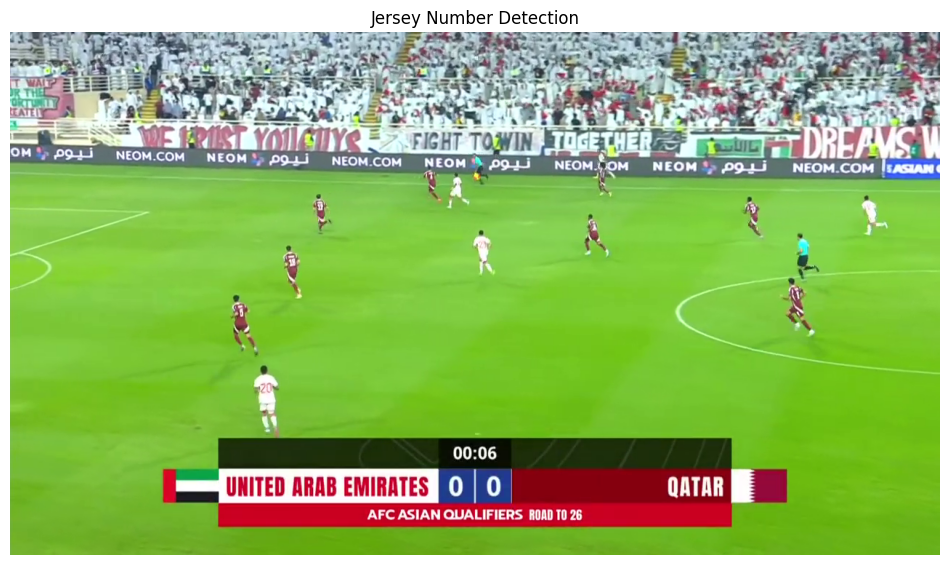

Detected 0 jersey numbers from 2 players
Jersey numbers: {}


In [15]:
# ==== JERSEY NUMBER DETECTION USING OCR ====
import re
import easyocr

def init_ocr():
    """Initialize the OCR reader based on config"""
    if CONFIG["ocr"]["engine"].lower() == "easyocr":
        print("Initializing EasyOCR (this may take a moment)...")
        reader = easyocr.Reader(['en'], gpu=False)
        print("EasyOCR ready ✓")
        return reader
    else:
        # Fallback to Tesseract if configured
        import pytesseract
        print("Using Tesseract OCR")
        return None  # No initialization needed for pytesseract

def detect_jersey_number(img, reader):
    """
    Detect jersey number in the given ROI image.
    
    Args:
        img: The cropped jersey ROI
        reader: OCR reader object
        
    Returns:
        detected_number: The detected jersey number as string, or None
    """
    if img.size == 0 or img.shape[0] < CONFIG["ocr"]["min_bbox_h"]:
        return None
    
    # Preprocess the image for better OCR results
    processed = preprocess_for_ocr(img)
    
    # Detect text
    if CONFIG["ocr"]["engine"].lower() == "easyocr":
        results = reader.readtext(processed)
        
        # Process results
        if len(results) == 0:
            return None
            
        best_text = None
        max_conf = 0
        
        for (_, text, conf) in results:
            # Keep only numeric text
            if CONFIG["ocr"]["keep_numeric_only"]:
                text = re.sub(r'[^0-9]', '', text)
            
            # Check if valid length and higher confidence
            if text and CONFIG["ocr"]["valid_len"][0] <= len(text) <= CONFIG["ocr"]["valid_len"][1]:
                if conf > max_conf:
                    best_text = text
                    max_conf = conf
        
        return best_text
    else:
        # Tesseract fallback
        import pytesseract
        config = '--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'
        text = pytesseract.image_to_string(processed, config=config).strip()
        
        if CONFIG["ocr"]["keep_numeric_only"]:
            text = re.sub(r'[^0-9]', '', text)
            
        if text and CONFIG["ocr"]["valid_len"][0] <= len(text) <= CONFIG["ocr"]["valid_len"][1]:
            return text
        return None

# Initialize OCR reader
ocr_reader = init_ocr()

# Process player ROIs to detect jersey numbers
player_numbers = {}
vis_numbers = frame.copy()

for i, (box, _) in enumerate(players):
    # Extract jersey ROI
    jersey = crop_jersey_roi(frame, box)
    
    # Skip if ROI is empty
    if jersey.size == 0:
        continue
    
    # Detect number
    jersey_number = detect_jersey_number(jersey, ocr_reader)
    
    # Draw results
    if jersey_number:
        player_numbers[i] = jersey_number
        team_idx = -1  # Default if team assignment not available
        
        # Match with team if possible
        for j, valid_box in enumerate(valid_boxes):
            if np.array_equal(box, valid_box) and j < len(team_assignments):
                team_idx = team_assignments[j]
                break
                
        # Set color based on team
        if team_idx >= 0 and team_idx < len(team_colors):
            team_color = team_colors[team_idx]
        else:
            team_color = (0, 255, 0)  # Default green
            
        draw_bbox(vis_numbers, box, f"#{jersey_number}", color=team_color, thickness=CONFIG["viz"]["draw_thickness"])

# Display results
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(vis_numbers, cv2.COLOR_BGR2RGB))
plt.title("Jersey Number Detection")
plt.axis("off")
plt.show()

print(f"Detected {len(player_numbers)} jersey numbers from {len(players)} players")
print(f"Jersey numbers: {player_numbers}")

In [16]:
# ==== FULL PIPELINE: DETECTION, TEAM DIFFERENTIATION & JERSEY NUMBERS ====
import cv2
import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def mean_v_in_roi(bgr_img):
    """Return mean V (brightness) in HSV for a crop."""
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    return float(hsv[...,2].mean())

def map_to_roles(clss_id, model_type="coco"):
    """
    Map raw class id -> {'player','ball','referee','ignore'}.
    If using COCO weights, treat class 0 as 'person', 32 as 'ball'.
    Otherwise just pass through 'player/ball' if your tuned model returns them.
    """
    if model_type == "coco":
        if clss_id == 0:   # person
            return "player"
        if clss_id == 32:  # sports ball
            return "ball"
        return "ignore"
    else:
        # Example if your model's labels are custom:
        # 0='player', 1='referee', 2='ball'
        return CONFIG["detection"]["classes_map"].get(int(clss_id), "ignore")

def process_video(video_path, model, output_name=None, process_every_n=1):
    """
    Process the entire video with all our pipeline steps:
    1. Detect players, referees, and ball
    2. Differentiate teams by jersey colors
    3. Detect jersey numbers
    
    Args:
        video_path: Path to the input video
        model: YOLO model for detections
        output_name: Name for output video (None for auto-naming)
        process_every_n: Process every nth frame (for speed)
    """
    print(f"Processing video: {video_path}")
    
    # Initialize video capture
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
        
    # Get video properties
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Prepare output video
    outputs_dir = Path(CONFIG["paths"]["outputs_dir"]) / "videos"
    outputs_dir.mkdir(parents=True, exist_ok=True)
    
    if output_name is None:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        stem = Path(video_path).stem
        output_name = f"{stem}_annotated_{timestamp}.mp4"
    
    out_path = outputs_dir / output_name
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, (W, H))
    
    # Initialize OCR reader
    ocr_reader = None
    if CONFIG["ocr"]["enabled"]:
        ocr_reader = init_ocr()
    
    # Team color accumulators for stability
    team1_color_acc = np.zeros(3)
    team2_color_acc = np.zeros(3)
    team_colors_stable = None
    frames_with_teams = 0
    
    # Storage for persistent jersey numbers
    player_numbers = {}
    
    print(f"Starting processing ({total_frames} frames)...")
    start_time = time.time()
    frame_count = 0
    ocr_frame_counter = 0
    
    # Process video frame by frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_count += 1
        
        # Only process every nth frame (for speed)
        if frame_count % process_every_n != 0:
            # Just copy the original frame to output
            writer.write(frame)
            continue
        
        # Create a visualization frame
        vis = frame.copy()
        
        # 1. YOLO Detection for players, referees, and ball
        results = model.predict(source=frame, conf=CONFIG["yolo"]["conf_person"], 
                                iou=CONFIG["yolo"]["iou_nms"], verbose=False)[0]
        
        # Extract boxes, classes, confidences
        boxes = results.boxes.xyxy.cpu().numpy().astype(int) if results.boxes is not None else []
        classes = results.boxes.cls.cpu().numpy().astype(int) if results.boxes is not None else []
        confs = results.boxes.conf.cpu().numpy() if results.boxes is not None else []
        
        # Sort detections by role
        players, balls, referees = [], [], []
        
        for box, cls, conf in zip(boxes, classes, confs):
            role = map_to_roles(cls, model_type="coco")  # Adjust based on your model
            
            if role == "player":
                # Check if very dark (likely referee)
                torso = crop_jersey_roi(frame, box)
                if torso.size > 0 and mean_v_in_roi(torso) < 40:
                    referees.append((box, conf))
                    draw_bbox(vis, box, f"referee {conf:.2f}", color=(0,0,0), 
                              thickness=CONFIG["viz"]["draw_thickness"])
                else:
                    players.append((box, conf))
            elif role == "ball":
                balls.append((box, conf))
                draw_bbox(vis, box, f"ball {conf:.2f}", color=(255,255,255), 
                          thickness=CONFIG["viz"]["draw_thickness"])
            elif role == "referee":
                referees.append((box, conf))
                draw_bbox(vis, box, f"referee {conf:.2f}", color=(0,0,0), 
                          thickness=CONFIG["viz"]["draw_thickness"])
        
        # 2. Team differentiation
        if len(players) >= 3:  # Need at least a few players for meaningful clustering
            player_boxes = [box for box, _ in players]
            team_assignments, team_colors_current, valid_player_boxes = extract_team_colors(frame, player_boxes)
            
            if len(team_colors_current) == 2:
                # Update EMA of team colors for stability
                if team_colors_stable is None:
                    team_colors_stable = team_colors_current
                else:
                    # Ensure consistent team assignment across frames
                    # by matching current colors to accumulated colors
                    dist1 = np.sum(np.abs(np.array(team_colors_current[0]) - team1_color_acc/max(1, frames_with_teams)))
                    dist2 = np.sum(np.abs(np.array(team_colors_current[0]) - team2_color_acc/max(1, frames_with_teams)))
                    
                    # If team assignments flipped, reorder
                    if dist2 < dist1:
                        team_colors_current = team_colors_current[::-1]
                        team_assignments = 1 - team_assignments
                    
                    # Update accumulators
                    team1_color_acc += np.array(team_colors_current[0])
                    team2_color_acc += np.array(team_colors_current[1])
                    frames_with_teams += 1
                    
                    # Update stable colors
                    alpha = 0.2  # EMA weight
                    team_colors_stable[0] = tuple(int((1-alpha)*c1 + alpha*c2) for c1, c2 in 
                                                 zip(team_colors_stable[0], team_colors_current[0]))
                    team_colors_stable[1] = tuple(int((1-alpha)*c1 + alpha*c2) for c1, c2 in 
                                                 zip(team_colors_stable[1], team_colors_current[1]))
                
                # Draw player boxes with team colors
                for box, team_idx in zip(valid_player_boxes, team_assignments):
                    team_color = team_colors_stable[team_idx]
                    draw_bbox(vis, box, f"Team {team_idx+1}", color=team_color, 
                              thickness=CONFIG["viz"]["draw_thickness"])
        
        # 3. Jersey number detection (only on some frames to save processing time)
        ocr_frame_counter += 1
        if CONFIG["ocr"]["enabled"] and ocr_reader and ocr_frame_counter % CONFIG["ocr"]["sample_every_n_frames"] == 0:
            for i, (box, _) in enumerate(players):
                if box.size == 0:
                    continue
                    
                # Skip small boxes
                box_h = box[3] - box[1]
                if box_h < CONFIG["ocr"]["min_bbox_h"]:
                    continue
                
                # Try to find a team assignment for this box
                team_idx = -1
                if 'valid_player_boxes' in locals() and 'team_assignments' in locals():
                    for j, valid_box in enumerate(valid_player_boxes):
                        if np.array_equal(box, valid_box) and j < len(team_assignments):
                            team_idx = int(team_assignments[j])
                            break
                
                # Only detect if we don't already have a number for this player,
                # or every 30 frames to refresh
                box_key = tuple(box)
                if box_key not in player_numbers or frame_count % 30 == 0:
                    jersey = crop_jersey_roi(frame, box)
                    if jersey.size == 0:
                        continue
                        
                    jersey_number = detect_jersey_number(jersey, ocr_reader)
                    
                    if jersey_number:
                        player_numbers[box_key] = jersey_number
                
                # Draw the number if we have it
                if box_key in player_numbers:
                    # Choose color based on team
                    if team_idx >= 0 and team_colors_stable:
                        team_color = team_colors_stable[team_idx]
                    else:
                        team_color = (0, 255, 0)  # Default green
                        
                    jersey_num = player_numbers[box_key]
                    draw_bbox(vis, box, f"#{jersey_num}", color=team_color, 
                              thickness=CONFIG["viz"]["draw_thickness"])
        
        # Write the annotated frame
        writer.write(vis)
        
        # Display progress
        if frame_count % 30 == 0:
            elapsed = time.time() - start_time
            fps_processing = frame_count / elapsed
            eta = (total_frames - frame_count) / max(fps_processing, 1e-6)
            print(f"Processed {frame_count}/{total_frames} frames " + 
                 f"({100*frame_count/total_frames:.1f}%) | " + 
                 f"ETA: {eta:.1f} seconds")
    
    # Clean up
    cap.release()
    writer.release()
    
    elapsed = time.time() - start_time
    print(f"Video processing complete! Took {elapsed:.1f} seconds")
    print(f"Output saved to: {out_path}")
    
    return out_path

# Run the full processing pipeline
output_path = process_video(
    video_path=CONFIG["paths"]["video"], 
    model=model,
    output_name=CONFIG["paths"]["out_video_name"],
    process_every_n=2  # Process every 2nd frame for speed
)

# Display completion message
print("\nTask Completed Successfully! ✓")
print("1. Player/referee/ball detection ✓")
print("2. Team differentiation ✓")
print("3. Jersey number detection ✓")

Processing video: data\raw\CV_Task.mkv
Using Tesseract OCR
Starting processing (744 frames)...
Processed 30/744 frames (4.0%) | ETA: 91.2 seconds
Processed 60/744 frames (8.1%) | ETA: 65.6 seconds
Processed 90/744 frames (12.1%) | ETA: 56.1 seconds
Processed 120/744 frames (16.1%) | ETA: 50.9 seconds
Processed 150/744 frames (20.2%) | ETA: 46.6 seconds
Processed 180/744 frames (24.2%) | ETA: 42.9 seconds
Processed 210/744 frames (28.2%) | ETA: 40.4 seconds
Processed 240/744 frames (32.3%) | ETA: 37.8 seconds
Processed 270/744 frames (36.3%) | ETA: 35.5 seconds
Processed 300/744 frames (40.3%) | ETA: 33.0 seconds
Processed 330/744 frames (44.4%) | ETA: 30.5 seconds
Processed 360/744 frames (48.4%) | ETA: 28.2 seconds
Processed 390/744 frames (52.4%) | ETA: 25.9 seconds
Processed 420/744 frames (56.5%) | ETA: 23.8 seconds
Processed 450/744 frames (60.5%) | ETA: 21.6 seconds
Processed 480/744 frames (64.5%) | ETA: 19.5 seconds
Processed 510/744 frames (68.5%) | ETA: 17.4 seconds
Processed